### LAB.5


Filippo Cucchetto(matr. 2110510)

### Ex.1

Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm, use a Norm (0,1) as random-walk candidate density

In [ ]:
metropolis.1dm=function(func,theta.init,n.sample,sigma){
    theta.cur=theta.init
    func.Cur=func(theta.cur)
    func.Samp=matrix(data=NA,nrow=n.sample,ncol=2+1)
    n.accept=0
    rate.accept=0.0
    for(n in 1:n.sample){
        theta.prop=rnorm(n=1,mean=0,sigma)
        func.Prop=func(theta.prop)
        logMR=func.Prop-func.Cur 

        if(logMR>=0 || logMR>log10(runif(1))){

            theta.cur=theta.prop
            func.Cur=func.Prop
            n.accept=n.accept+1
        }
        func.Samp[n,1]=func.Cur
        func.Samp[n,2]=theta.cur
        }
    return(func.Samp)
    }

posterior=function(theta){
    return(0.5*exp((-1*((theta+3))^2)/2)+0.5*exp((-1*((theta-3)^2))/2))
}
post.metropolis=function(theta){
    return(log10(posterior(theta)))
}
theta.init=-5
sample.sig=1
n.sample=10^5
demo=TRUE
set.seed(20190513)
chain=metropolis.1dm(func=post.metropolis,theta.init=theta.init,n.sample=n.sample,sigma=sample.sig^2)
z=chain[,2]

plot the sampled distribution

In [ ]:
x=seq(-50, 50, length.out=10^4)
y=posterior(x)
ymax=1.05 * max(y)
plot(x, y, ylim=c(0,max(y)*1.10),type='l',lty=2,col='blue')
sa=which(z>=min(x) & z<=max(x))
hist=hist(z[sa], breaks=seq(from=min(x), to=max(x),length.out=100), plot=FALSE)
# Compute normalization function: used later to put on same as histogram
Zfunc=sum(y)*diff(range(x))/(length(x))
 
Zhist=sum(hist$counts)*diff(range(hist$breaks))/(length(hist$counts))
lines(hist$breaks, c(hist$counts*Zfunc/Zhist,0),col='navy', type="s", lwd=2, lty=5)
leg.labels = c('analytical', 'MCMC')
leg.ltype = c(1, 5)
leg.colors = c('blue','navy')
legend("topleft", inset=.05, bty='n',
legend = leg.labels, lty=leg.ltype, col=leg.colors,lwd = 2)

analyze the chain with the CODA package and plot the chain autocorrelation

In [ ]:
library(coda)
cChain1=as.mcmc((z))
myLags=seq(0,500,by=1)
y1=autocorr(cChain1,lags=myLags)
plot(myLags,y1,col='red',xlab='lag',ylab='ACF')
cat(" For Sigma equal to",1,"we have that the sample sized autocorrelation is",effectiveSize(cChain1),"\n")

try to use different burn-in cycles and thinning and plot the corresponding posterior distribution
and the chain autocorrelation function. What are the best parameters ?

In [ ]:

cChain2=as.mcmc((z[1:3000]))
myLags=seq(0,500,by=1)
y1=autocorr(cChain2,lags=myLags)
plot(myLags,y1,col='red',xlab='lag',ylab='ACF')
cat(" For Sigma equal to",1,"we have that the sample sized autocorrelation is",effectiveSize(cChain2),"\n")

### EXERCISE 2

In [145]:
Y=c(-7.821,-1.494,-15.444,-10.807,-13.735,-14.442,-15.892,-18.326)
X=c(5,6,7,8,9,10,11,12)


Perform a simple linear regression model running a Markov Chain Monte Carlo with JAGS

In [146]:
library(R2jags)
dat=data.frame(X=X,Y=Y)
jagsdata=with(dat,list(X=X,Y=Y,N=length(X)))
lm1_jags <- function(){
	# Likelihood:
	for (i in 1:N){
		Y[i] ~ dnorm(mu[i], sigma) 
		mu[i] <- alpha + beta * X[i]
	}
	# Priors:
	alpha ~ dnorm(0, 10) # intercept
	beta ~ dnorm(-1, 3) # slope
	sigma ~ dunif(0.034,4) # standard deviation
	
}
init_values <- function(){
	list(alpha = rnorm(1), beta = rnorm(1), sigma = runif(1))
}

params=c("alpha", "beta", "sigma")



Number of chains=3, burnins=2000, iterations=12000

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 43

Initializing model



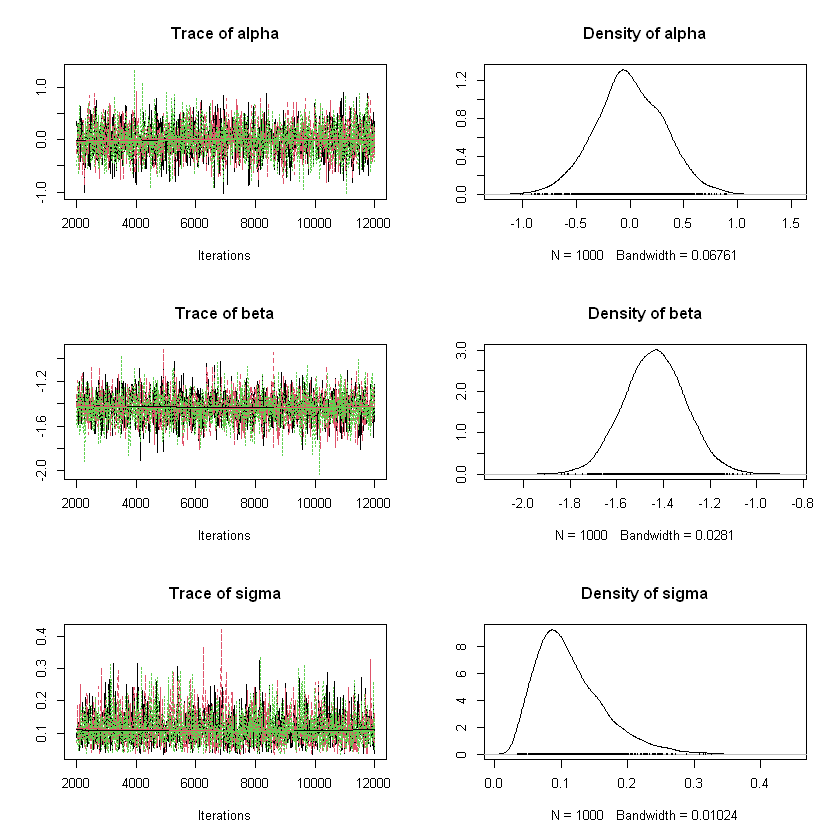

In [147]:
fit_lm1=jags(data = jagsdata, inits = init_values, parameters.to.save = params, model.file = lm1_jags,n.chains = 3, n.iter = 12000, n.burnin = 2000, n.thin = 10, DIC = F)
lm1_mcmc <- as.mcmc(fit_lm1) #Create the markov Chain
nvalues <- 100
Xempirical <- seq(min(X), max(X), length.out = nvalues)
lm1_mcmc_combi <- as.mcmc(rbind(lm1_mcmc[[1]], lm1_mcmc[[2]], lm1_mcmc[[3]]))
z=mean(lm1_mcmc_combi[,"alpha"])+Xempirical*mean(lm1_mcmc_combi[,"beta"])
lm1_mcmc <- as.mcmc(fit_lm1)
plot(lm1_mcmc)

Compute the  95% Credibility Interval and fitting the line

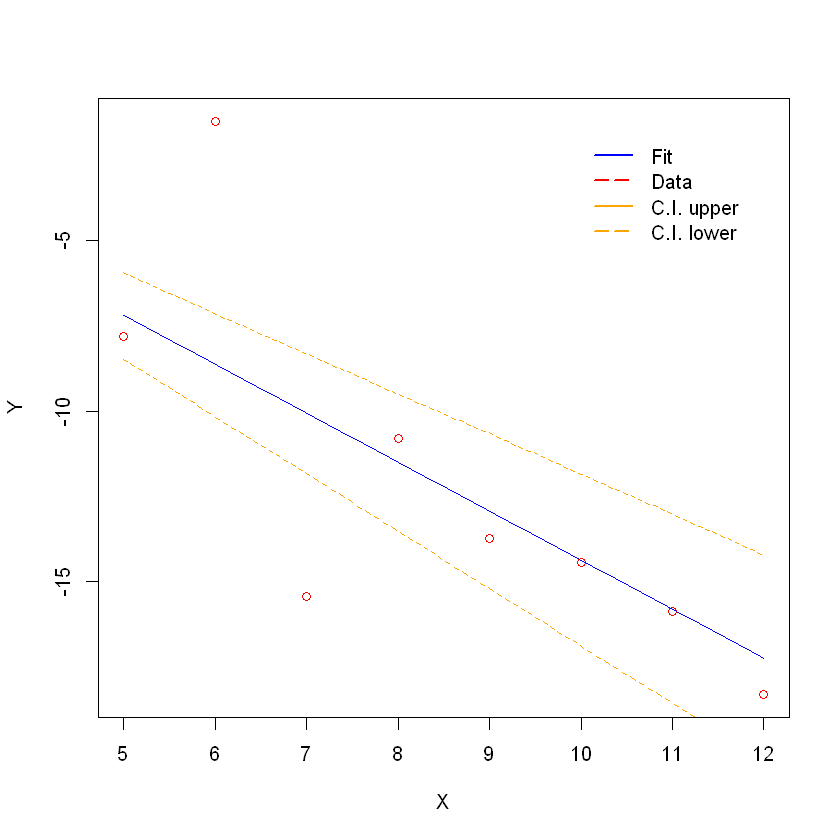

In [148]:
pred_mean_dist <- matrix(NA, nrow = nrow(lm1_mcmc_combi), ncol = nvalues)
for (i in 1:nrow(pred_mean_dist)){
	pred_mean_dist[i,] <- lm1_mcmc_combi[i,"alpha"] + Xempirical * lm1_mcmc_combi[i,"beta"]
}

credible_lower <- apply(pred_mean_dist, MARGIN = 2, quantile, prob = 0.025)
credible_upper <- apply(pred_mean_dist, MARGIN = 2, quantile, prob = 0.975)
plot(Y ~ X, data = dat,col='red')
lines(Xempirical,z,type='l',col='blue')
lines(Xempirical, credible_lower, lty = 2,col='orange')
lines(Xempirical, credible_upper, lty = 2,col='orange')
leg.labels = c('Fit', 'Data','C.I. upper','C.I. lower')
leg.ltype = c(1, 5)
leg.colors = c('blue','red','orange','orange')
legend("topright", inset=.05, bty='n',legend = leg.labels, lty=leg.ltype, col=leg.colors,lwd = 2)

Different burnin and n.thin value (5000,100) number of chains 1

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 43

Initializing model



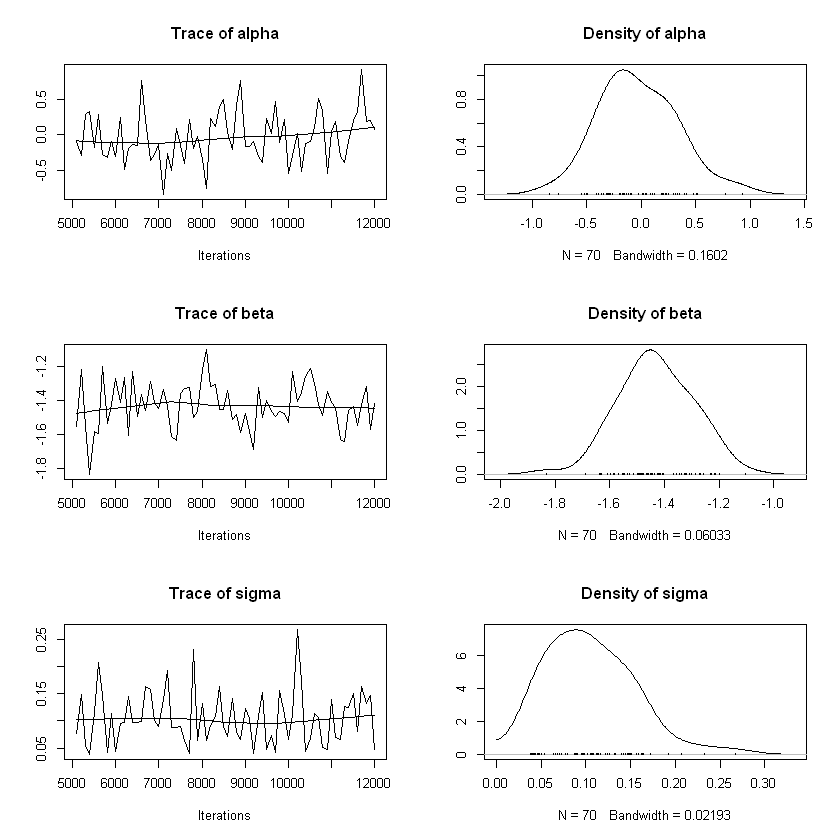

In [149]:
fit_lm1=jags(data = jagsdata, inits = init_values, parameters.to.save = params, model.file = lm1_jags,n.chains = 1, n.iter = 12000, n.burnin = 5000, n.thin = 100, DIC = F)

lm1_mcmc <- as.mcmc(fit_lm1) #Create the markov Chain
nvalues <- 100
Xempirical <- seq(min(X), max(X), length.out = nvalues)
lm1_mcmc <- as.mcmc(fit_lm1)
plot(lm1_mcmc)

I need to compute the Jacobian of the following transformation
$$
    \sigma=\frac{1}{\sqrt{c}}

$$
Then from this I have that:

$$

    p(c)=\frac{p(\sigma)}{2 \sqrt{\sigma^3}}

$$

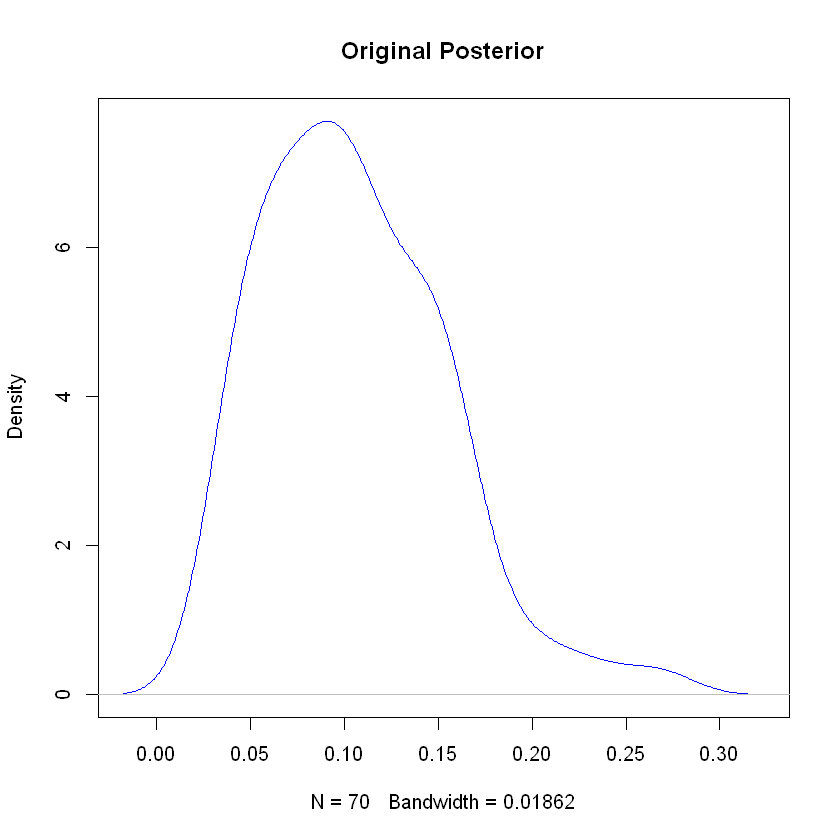

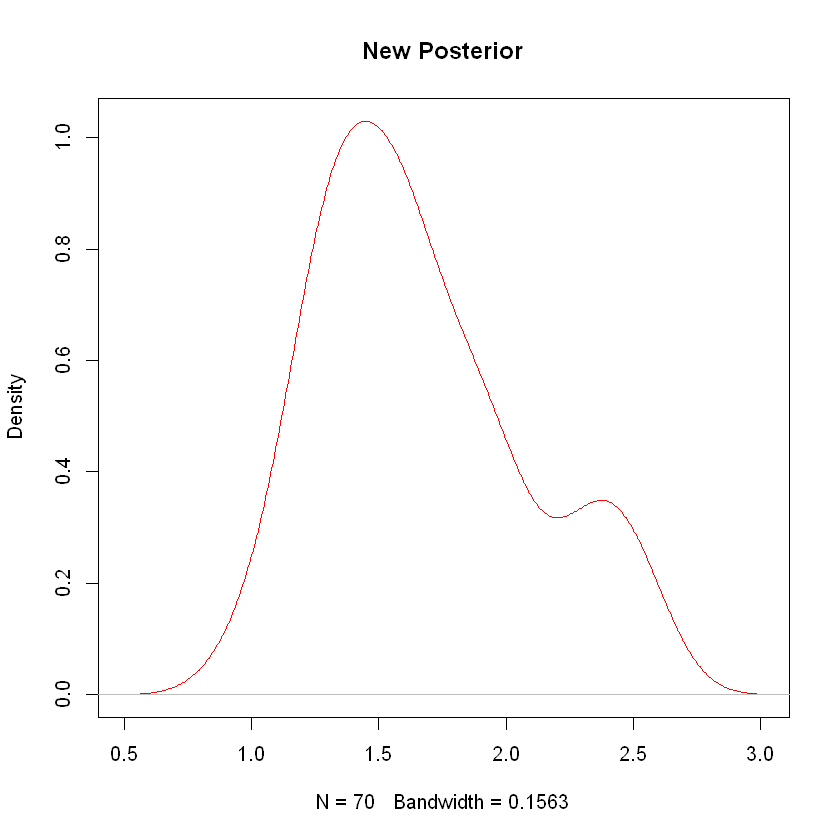

In [175]:
s=unlist(lm1_mcmc[,"sigma"])
stransformed=2*sqrt(s^3)
a=s/stransformed
plot(density(s), main="Original Posterior", col="blue")
plot(density(a),main="New Posterior",col="red")

### Exercise 3

In [ ]:
x=c(2.06,5.56,7.93,6.56,205)


In [ ]:
library(R2jags)


dat=data.frame(X=x)
jagsdata=with(dat,list(X=x,N=length(x)))

P_jags <- function(){
	# Likelihood:
	for (i in 1:N){
		X[i] ~ dnorm(mu, sigma) 
	}
	# Priors:
	mu ~ dunif(-10,10)
	sigma ~ dunif(0,50) # standard deviation
	
}
init_values <- function(){
	list(mu =0, sigma =1)
}
params=c("mu", "sigma")


In [ ]:
set.seed(42)
fit_lm2=jags(data = jagsdata, inits = init_values, parameters.to.save = params, 
model.file = P_jags,n.chains = 1, n.iter = 150000, n.burnin =2000, n.thin = 100, DIC = F)
mcChain2=as.mcmc(fit_lm2)
plot(mcChain2)

We implement the jacobian of the trasformation from 
$$

m -> \frac{m}{s}
$$
We get that:

$$
p(m')=\frac{p(m)}{s}
$$

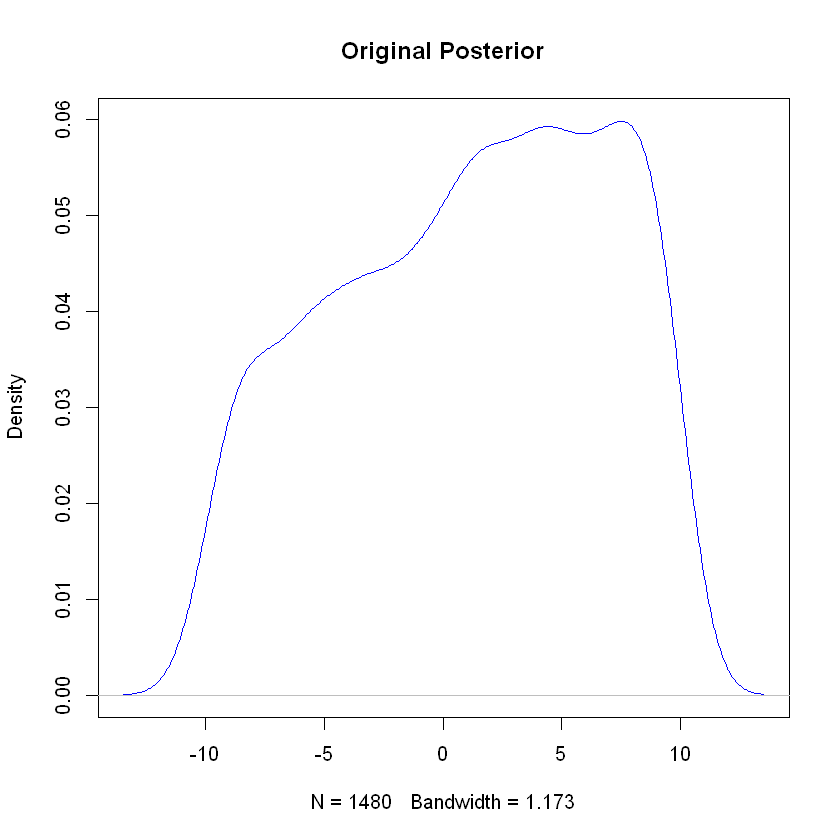

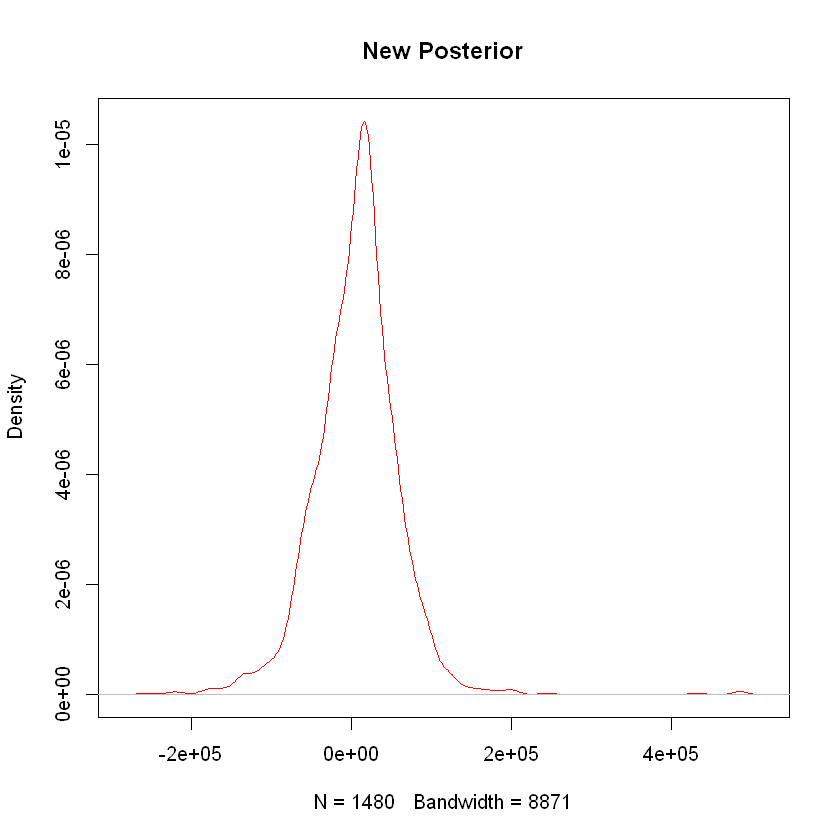

In [178]:
MU=unlist(mcChain2[,"mu"])
MuTrans=(unlist(mcChain2[,"sigma"]))
A=MU/MuTrans
plot(density(MU), main="Original Posterior", col="blue")
plot(density(A),main="New Posterior",col="red")

### Exercise 4

In [ ]:
D=c(0.0032,0.0034,0.214,0.263,0.275,0.265,0.45,0.5,0.5,0.63,0.8,0.9,0.9,0.9,0.9,2,2,2,2)
V=c(170,290,-130,-70,-185,-220,200,290,270,200,920,450,500,500,960,500,850,800,1090)
norm=sqrt(sum(V^2))
library(R2jags)
Vnorm=V/norm # Rescaling the velocities to [0,1] interval


dat=data.frame(X=D,Y=Vnorm)
jagsdata=with(dat,list(X=D,Y=Vnorm,N=length(D)))

PP_jags <- function(){
	# Likelihood:
	for (i in 1:N){
		Y[i] ~ dnorm(b*X[i], c) 
	}
	# Priors:
	b ~ dunif(0,1)
	c ~ dunif(1,1.5) # standard deviation
	
}
init_values <- function(){
	list(b = 0.5, c =1.2)
}
params=c("b", "c")


In [ ]:
fit_lm3=jags(data = jagsdata, inits = init_values, parameters.to.save = params, 
model.file = PP_jags,n.chains = 1, n.iter = 150000, n.burnin =2000, n.thin = 100, DIC = F)
mcChain3=as.mcmc(fit_lm3)
plot(mcChain3)
B_list=unlist(mcChain3[,"b"])
C_list=unlist(mcChain3[,"c"])

In [ ]:
B_list=(unlist((mcChain3[,"b"])))
C_list=unlist(((mcChain3[,"c"])))
D_emp=seq(min(D),max(D),length.out = 1000)
B=mean(unlist(mcChain3[,"b"]))
C=mean(unlist(mcChain3[,"c"]))
V_emp=dnorm(B*D_emp,C)
l=length(C_list)
P=matrix(NA, nrow =l, ncol = 1000)
for(i in 1:l){
    P[i, ]=dnorm(D_emp*B_list[i],C_list[i])
}
CL=apply(P, MARGIN = 2, quantile, prob = 0.025)
CU=apply(P, MARGIN = 2, quantile, prob = 0.975)
plot(D,Vnorm,ylab="Normalized V",col="red")
lines(D_emp,V_emp,xlab="D",ylab="Y",type='l',col='blue')
lines(D_emp,CL,type='l',col='orange')
lines(D_emp,CU,type='l',col='orange')
leg.labels = c('Fit', 'Data','C.I. upper','C.I. lower')
leg.ltype = c(1, 5)
leg.colors = c('blue','red','orange','orange')
legend("topleft", inset=.05, bty='n',legend = leg.labels, lty=leg.ltype, col=leg.colors,lwd = 2)